In [2]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

from pprint import pprint

%matplotlib inline

In [3]:
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

In [3]:
#nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

# Loading Data and Pre-processing

In [4]:
my_columns = [
    'user_id', #1 user identifier
    'status_id', #1 status identifier
    #'created_at', #1 before or after debate
    #'screen_name', #1 profile screen name 
    'text', #1 tweet text
    'Y/N', #1 LABEL
    'display_text_width', #1 length
    'is_quote', #1 Whether the tweet is an original one or quoted one
    'favorite_count', #1
    'retweet_count',  #1
    #'quote_count', #1 All blank
    #'reply_count', #1 All blank
    'hashtags', #1
    'media_type', #1 contains just text or media (media = photo / video) contents: ‘photo’ / BLANK -> 'text'
    'mentions_screen_name', #1 Name
    #'quoted_source', #? TO BE DECIDED
    'followers_count', #1 info related to profile
    'friends_count', #1 info related to profile
    'listed_count', #1 info related to profile TO BE DECIDED
    'statuses_count', #1 info related to profile
    'favourites_count', #1 info related to profile
    'verified', #1 whether the profile is verified
]

In [5]:
file_name = 'proudboys-labelled.csv'
data_originial = pd.read_csv(file_name, encoding='ISO-8859-1')
data_originial = data_originial[my_columns]
print(data_originial.shape)

(2014, 17)


**Processing the Labels**

- Remove unlabled data
- Replace the original labels

In [6]:
# Remove the unlabeled data
data_originial = data_originial.dropna(subset=['Y/N'])
print(data_originial.shape)

(2014, 17)


In [7]:
data_originial['Supportive'] = data_originial['Y/N'].str.contains('Y')
data_originial['Offensive'] = data_originial['Y/N'].str.contains('O')

## Upsampling Supportive Class

In [8]:
from sklearn.utils import resample

# Separate majority and minority classes
df_majority = data_originial[data_originial['Supportive'] == False]
df_minority = data_originial[data_originial['Supportive'] == True]
print(df_majority.shape, df_minority.shape)

# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=1257,    # to match majority class
                                 random_state=0) # reproducible results
 
# Combine majority class with upsampled minority class
data = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
data.Supportive.value_counts()
# 1    576
# 0    576
# Name: balance, dtype: int64

(1257, 19) (757, 19)


True     1257
False    1257
Name: Supportive, dtype: int64

## Supportive

In [9]:
N = data.shape[0]
N_SUPPORTIVE = data['Supportive'].sum(axis=0)
N_NON_SUPPORTIVE = N - N_SUPPORTIVE

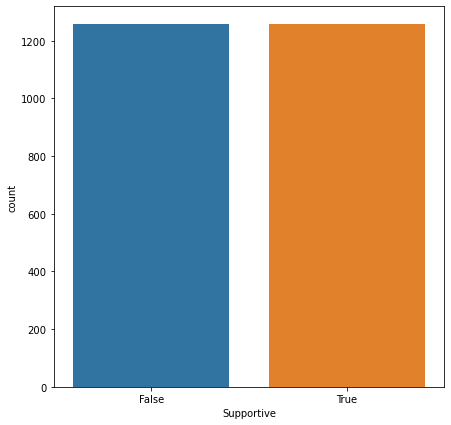

True     1257
False    1257
Name: Supportive, dtype: int64
False    2149
True      365
Name: Offensive, dtype: int64


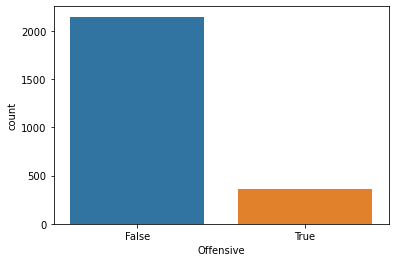

In [10]:
plt.figure(figsize=(7,7))
sns.countplot(data=data, x='Supportive')
plt.show()
print(data['Supportive'].value_counts())
sns.countplot(data=data, x='Offensive')
print(data['Offensive'].value_counts())
plt.show()

# Offensive

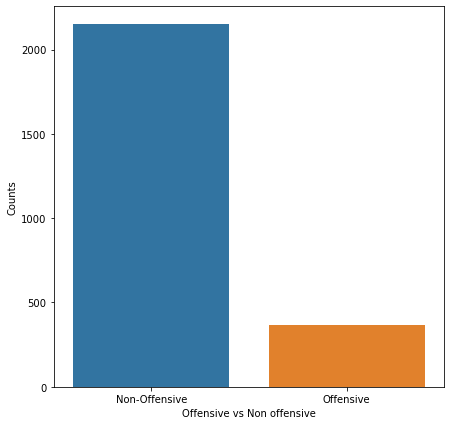

Non-Offensive    2149
Offensive         365
Name: Offensive, dtype: int64


In [11]:
#temp = data['Supportive'].map({False: 'Non-Supportive', True: 'Supportive'})
temp = data['Offensive'].map({False: 'Non-Offensive', True: 'Offensive'})
temp.head()
plt.figure(figsize=(7,7))
sns.countplot(x=temp)
plt.xlabel('Offensive vs Non offensive')
plt.ylabel('Counts')
plt.show()
print(temp.value_counts())

In [12]:
data['media_type'] = data['media_type'].fillna('plain_text')

   Supportive  media_type  percentage
1       False       photo    8.591885
3        True       photo    6.284805
0       False  plain_text   91.408115
2        True  plain_text   93.715195


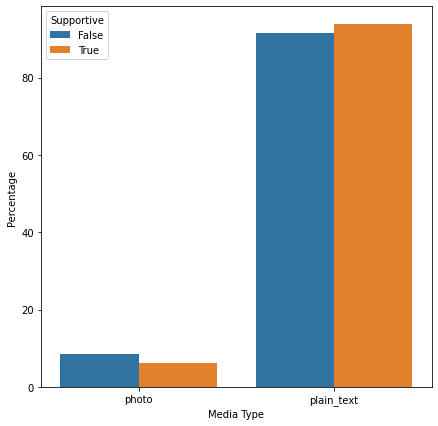

In [13]:
media_counts = (data.groupby(['Supportive'])['media_type']
             .value_counts(normalize=True)
             .rename('percentage')
             .mul(100)
             .reset_index()
             .sort_values('media_type'))

print(media_counts)
plt.figure(figsize=(7,7))
p = sns.barplot(data=media_counts, x='media_type', y='percentage', hue='Supportive')
p.set(xlabel='Media Type', ylabel='Percentage')
plt.show()

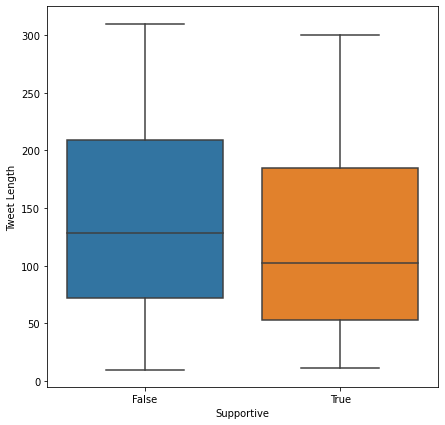

In [14]:
plt.figure(figsize=(7,7))
p = sns.boxplot(y='display_text_width',x='Supportive',data=data)
p.set(xlabel='Supportive', ylabel='Tweet Length')
plt.show()

In [15]:
data.groupby(['Supportive'])['display_text_width'].describe()

,count,mean,std,min,25%,50%,75%,max
Supportive,,,,,,,,
False,1257.0,141.724741,80.350143,10.0,72.0,128.0,209.0,310.0
True,1257.0,122.321400,80.804731,11.0,53.0,102.0,185.0,300.0


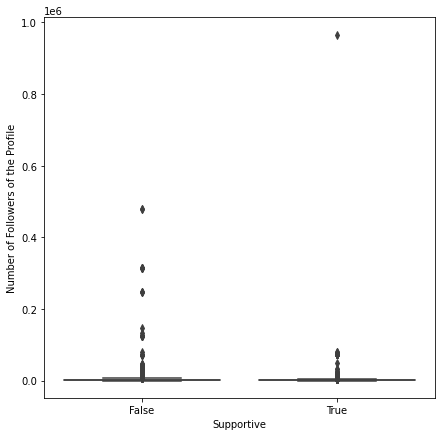

In [16]:
plt.figure(figsize=(7,7))
p = sns.boxplot(y='followers_count',x='Supportive',data=data)
p.set(xlabel='Supportive', ylabel='Number of Followers of the Profile')
plt.show()

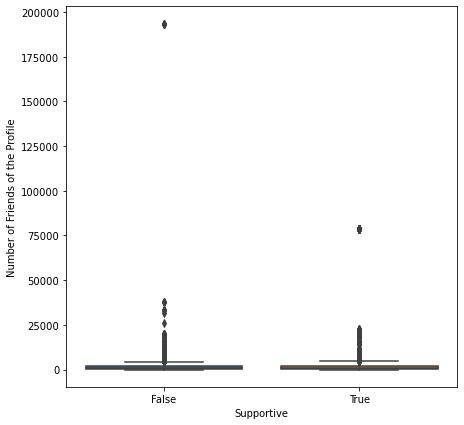

In [17]:
plt.figure(figsize=(7,7))
p = sns.boxplot(y='friends_count',x='Supportive',data=data)
p.set(xlabel='Supportive', ylabel='Number of Friends of the Profile')
plt.show()

In [156]:
#print(data['followers_count'].sort_values(ascending=False)[:50])

   Supportive  verified  percentage
0       False     False   97.692920
2        True     False   99.761337
1       False      True    2.307080
3        True      True    0.238663


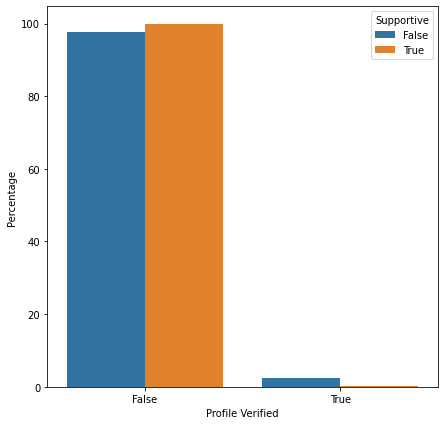

In [18]:
verified_profile = (data.groupby(['Supportive'])['verified']
             .value_counts(normalize=True)
             .rename('percentage')
             .mul(100)
             .reset_index()
             .sort_values('verified'))

print(verified_profile)
plt.figure(figsize=(7,7))
p = sns.barplot(data=verified_profile, x='verified', y='percentage', hue='Supportive')
p.set(xlabel='Profile Verified', ylabel='Percentage')
plt.show()

**Processing the Hashtags**

Replace:
    
- 'alllivesmatters' -> 'alllivesmatter'
- 'antifacist', 'antifascists' -> 'antifa'
- 'blacklivesmatter', 'blacklivesstillmatter', 'blacklivesmatter' -> 'blm'
- 'kag2020' -> 'kag'
- 'maga2020' -> 'maga'
- 'oregoncity' -> 'oregon'
- 'portlandprotestors' -> 'portlandprotesters'
- 'protests', 'protest2020', 'protests2020' -> 'protest'
- 'trump2020' -> 'trump'

In [19]:
data['mentions_screen_name'] = data['mentions_screen_name'].fillna('blank')

In [20]:
data['hashtags_proc'] = data['hashtags'].str.lower()
data['hashtags_proc'] = data['hashtags_proc'].fillna('blank')

ht_replacements = {
    'alllivesmatters': 'alllivesmatter',
    'antifacist': 'antifa',
    'antifascists':'antifa',
    'blacklivesmatter': 'blm',
    'blacklivesstillmatter': 'blm',
    'blacklivematter': 'blm',
    'kag2020': 'kag',
    'maga2020': 'maga',
    'oregoncity': 'oregon',
    'portlandprotestors': 'portlandprotesters',
    'protests': 'protest',
    'protest2020': 'protest',
    'protests2020': 'protest',
    'trump2020': 'trump',
}

for k, v in ht_replacements.items():
    data['hashtags_proc'] = data['hashtags_proc'].str.replace(k, v, regex=True)

## Adding New Features

In [21]:
data['hashtags_count'] = data['hashtags'].apply(lambda x: len(x.split()) if pd.notnull(x) else 0)
data['hashtags_count'] = data['hashtags_count'].apply(lambda n: 3 if n > 2 else n)

data['hashtags_count'].head()

0    0
1    0
2    0
4    0
5    3
Name: hashtags_count, dtype: int64

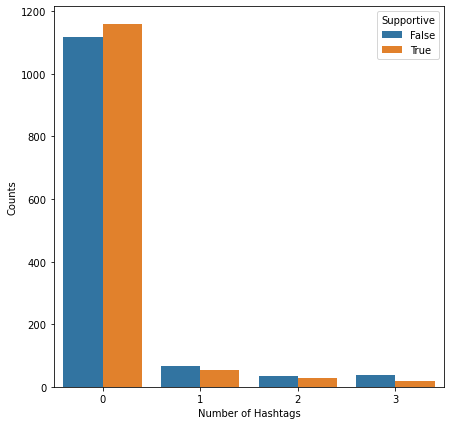

Supportive  hashtags_count
False       0                 1119
            1                   66
            3                   37
            2                   35
True        0                 1158
            1                   54
            2                   27
            3                   18
Name: hashtags_count, dtype: int64


In [22]:
plt.figure(figsize=(7,7))
p = sns.countplot(x='hashtags_count', hue='Supportive', data=data)
p.set(xlabel='Number of Hashtags', ylabel='Counts')
plt.show()
print(data.groupby(['Supportive'])['hashtags_count'].value_counts())

   Supportive  hashtags_count  percentage
0       False               0   89.021480
4        True               0   92.124105
1       False               1    5.250597
5        True               1    4.295943
3       False               2    2.784407
6        True               2    2.147971
2       False               3    2.943516
7        True               3    1.431981


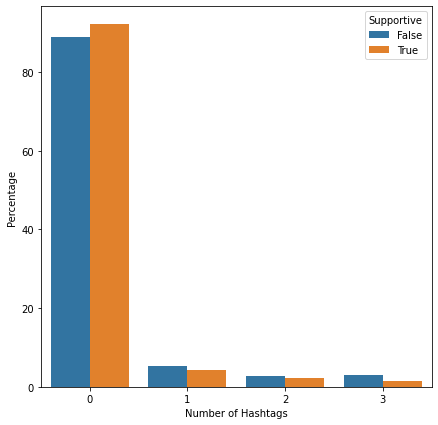

In [23]:
ht_counts = (data.groupby(['Supportive'])['hashtags_count']
             .value_counts(normalize=True)
             .rename('percentage')
             .mul(100)
             .reset_index()
             .sort_values('hashtags_count'))

print(ht_counts)
plt.figure(figsize=(7,7))
p = sns.barplot(data=ht_counts, x='hashtags_count', y='percentage', hue='Supportive')
p.set(xlabel='Number of Hashtags', ylabel='Percentage')
plt.show()

In [24]:
data['mention_count'] = data['mentions_screen_name'].apply(lambda x: len(x.split()) if pd.notnull(x) else 0)
data['mention_count'] = data['mention_count'].apply(lambda n: 4 if n > 3 else n)

data['mention_count'].head()

0    1
1    2
2    1
4    2
5    1
Name: mention_count, dtype: int64

   Supportive  mention_count  percentage
0       False              1   70.405728
4        True              1   68.814638
1       False              2   14.399364
5        True              2   19.888624
2       False              3    7.955449
6        True              3    6.284805
3       False              4    7.239459
7        True              4    5.011933


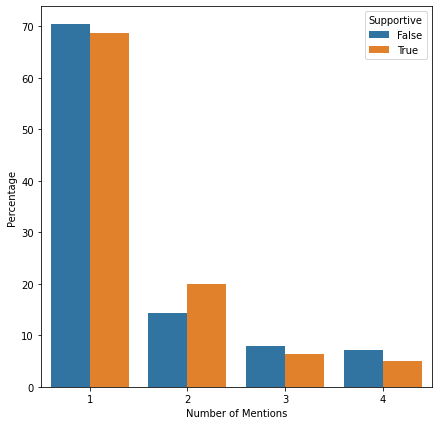

In [25]:
mention_counts = (data.groupby(['Supportive'])['mention_count']
             .value_counts(normalize=True)
             .rename('percentage')
             .mul(100)
             .reset_index()
             .sort_values('mention_count'))

print(mention_counts)
plt.figure(figsize=(7,7))
p = sns.barplot(data=mention_counts, x='mention_count', y='percentage', hue='Supportive')
p.set(xlabel='Number of Mentions', ylabel='Percentage')
plt.show()

In [26]:
data['exclamation_count'] = data['text'].str.count('\!')
data['exclamation_count'] = data['exclamation_count'].apply(lambda n: 3 if n > 2 else n)

data['question_count'] = data['text'].str.count('\?')
data['question_count'] = data['question_count'].apply(lambda n: 3 if n > 2 else n)

   Supportive  exclamation_count  percentage
0       False                  0   92.601432
4        True                  0   82.816229
1       False                  1    4.136834
5        True                  1   10.580748
2       False                  2    1.988862
6        True                  2    3.500398
3       False                  3    1.272872
7        True                  3    3.102625


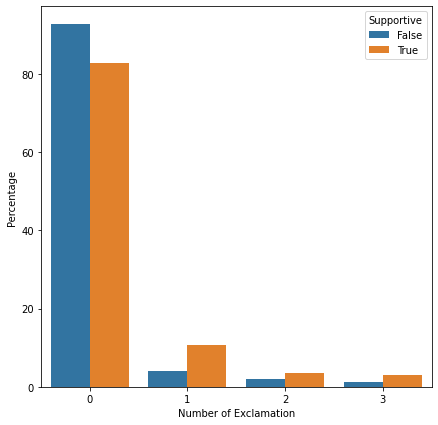

In [27]:
exclamation_counts = (data.groupby(['Supportive'])['exclamation_count']
             .value_counts(normalize=True)
             .rename('percentage')
             .mul(100)
             .reset_index()
             .sort_values('exclamation_count'))

print(exclamation_counts)
plt.figure(figsize=(7,7))
p = sns.barplot(data=exclamation_counts, x='exclamation_count', y='percentage', hue='Supportive')
p.set(xlabel='Number of Exclamation', ylabel='Percentage')
plt.show()

   Supportive  question_count  percentage
0       False               0   80.111376
4        True               0   82.498011
1       False               1   15.194909
5        True               1   10.978520
2       False               2    3.341289
6        True               2    4.057279
3       False               3    1.352426
7        True               3    2.466189


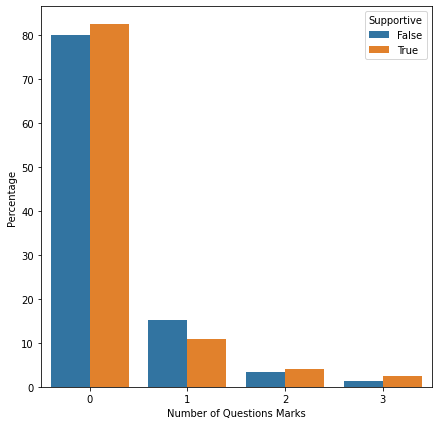

In [28]:
question_counts = (data.groupby(['Supportive'])['question_count']
             .value_counts(normalize=True)
             .rename('percentage')
             .mul(100)
             .reset_index()
             .sort_values('question_count'))

print(question_counts)
plt.figure(figsize=(7,7))
p = sns.barplot(data=question_counts, x='question_count', y='percentage', hue='Supportive')
p.set(xlabel='Number of Questions Marks', ylabel='Percentage')
plt.show()

In [29]:
#data.info()
#print(data['is_quote'].value_counts())
#print(data['media_type'].value_counts())
#print(data['verified'].value_counts())
#print(data['supportive'].value_counts())
#print(data['offensive'].value_counts())
#print(data['exclamation_count'].value_counts())
#print(data['question_count'].value_counts())
#print(data['hashtags_count'].value_counts())
#print(data['mention_count'].value_counts())
#print(data['followers_count'].value_counts().sort_index())

### Remove URLs, Hashtags, Mentions

In [30]:
data['text_proc'] = data['text'].str.lower()
data['text_proc'] = data['text_proc'].str.replace(r"http\S+", "", regex=True)
data['text_proc'] = data['text_proc'].str.replace(r"#\S+", "", regex=True)
data['text_proc'] = data['text_proc'].str.replace(r"@\S+", "", regex=True)

Pre-processing Steps:

    1. Lower case
    2. Word tokenize
    3. Removing numbers and punctuations
    4. Word stemming

In [31]:
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

for idx, row in data.iterrows():
    words = nltk.word_tokenize(row['text_proc'])
    words = [word for word in words if word.isalpha()]
    data.loc[idx, 'lem_text'] = ' '.join([lemmatizer.lemmatize(word) for word in words if word not in set(stopwords.words('english'))])
    words = [stemmer.stem(word) for word in words if word not in set(stopwords.words('english'))]
    data.loc[idx, 'text_proc'] = ' '.join(words)
    

data.head()

,user_id,status_id,text,Y/N,display_text_width,is_quote,favorite_count,retweet_count,hashtags,media_type,...,verified,Supportive,Offensive,hashtags_proc,hashtags_count,mention_count,exclamation_count,question_count,text_proc,lem_text
0,x382691414,x1297365508300447744,Proud boys are attacking Peaceful protesters i...,N,115,False,0,0,NaN,photo,...,False,False,False,blank,0,1,0,0,proud boy attack peac protest portland portlan...,proud boy attacking peaceful protester portlan...
1,x743936431,x1297365466306904066,"@Medde13 @MrAndyNgo I live in Portland, proud ...",N,189,False,0,0,NaN,plain_text,...,False,False,False,blank,0,2,0,0,live portland proud boy white supremacist hate...,live portland proud boy white supremacist hate...
2,x743936431,x1294749099976036353,Anyone else wondering why tRump and his deplor...,"N, O",175,False,9,0,NaN,plain_text,...,False,False,True,blank,0,1,0,1,anyon els wonder trump deplor base speak conde...,anyone else wondering trump deplorable base sp...
4,x176941218,x1297365411533643776,@MARCIAN2003 @JoshuaPotash The police and the ...,N,42,False,0,0,NaN,plain_text,...,False,False,False,blank,0,2,0,0,polic proud boy,police proud boy
5,x1119014143590305797,x1294746648653045760,"""Proud Boys"" are white supremacists, the Unite...","N, O",279,False,9,8,America EndFascismInAmerica NoMoreNazis StopTh...,plain_text,...,False,False,True,america endfascisminamerica nomorenazis stopth...,3,1,0,0,proud boy white supremacist unit state declar ...,proud boy white supremacist united state decla...


# Spell Checker
Based on this post: https://www.kaggle.com/cpmpml/spell-checker-using-word2vec

In [33]:
import gensim
model = gensim.models.KeyedVectors.load_word2vec_format('word2vecGoogleNewsvectorsmaster/GoogleNews-vectors-negative300.bin', binary=True)

In [34]:
words = model.index2word

In [35]:
w_rank = {}
for i,word in enumerate(words):
    w_rank[word] = i

WORDS = w_rank

In [36]:
import re
from collections import Counter

def words(text): return re.findall(r'\w+', text.lower())

def P(word): 
    "Probability of 'word'."
    # use inverse of rank as proxy
    # returns 0 if the word isn't in the dictionary
    return - WORDS.get(word, 0)

def correction(word): 
    "Most probable spelling correction for word."
    return max(candidates(word), key=P)

def candidates(word): 
    "Generate possible spelling corrections for word."
    return (known([word]) or known(edits1(word)) or known(edits2(word)) or [word])

def known(words): 
    "The subset of 'words' that appear in the dictionary of WORDS."
    return set(w for w in words if w in WORDS)

def edits1(word):
    "All edits that are one edit away from 'word'."
    letters    = 'abcdefghijklmnopqrstuvwxyz'
    splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
    deletes    = [L + R[1:]               for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
    replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
    inserts    = [L + c + R               for L, R in splits for c in letters]
    return set(deletes + transposes + replaces + inserts)

def edits2(word): 
    "All edits that are two edits away from 'word'."
    return (e2 for e1 in edits1(word) for e2 in edits1(e1))

In [61]:
#Spell Checker Quick Test
misspelled_word = 'kuickly'
print(correction(misspelled_word))

quickly


In [40]:
# Applying SpellChecker on 'proc_text' column

for idx, row in data.iterrows():
    words = nltk.word_tokenize(row['text_proc'])
    words = [correction(word) for word in words]
    data.loc[idx, 'spellchecked_text_proc'] = ' '.join(words)

In [43]:
data.tail()

,user_id,status_id,text,Y/N,display_text_width,is_quote,favorite_count,retweet_count,hashtags,media_type,...,Supportive,Offensive,hashtags_proc,hashtags_count,mention_count,exclamation_count,question_count,text_proc,lem_text,spellchecked_text_proc
1502,x961401594007887872,x1297307643569008642,Iâm glad someone is fighting back. Good for ...,Y,59,True,0,0,NaN,plain_text,...,True,False,blank,0,1,0,0,glad someon fight back good proud boy,glad someone fighting back good proud boy,glad someon fight back good proud boy
532,x1287513420678541314,x1297343222528843781,@grizzlywhisker @MrAndyNgo All of that huge cr...,"Y, S",71,False,2,1,NaN,plain_text,...,True,False,blank,0,2,0,2,huge crowd today antifa pretend proud boy,huge crowd today antifa pretending proud boy,huge crowd today anti pretend proud boy
756,x870811393364250624,x1297338358197190657,@sav_says_ @mikeandersonsr I wished I was in P...,Y,47,False,1,0,NaN,plain_text,...,True,False,blank,0,2,1,0,wish portland proud boy,wished portland proud boy,wish portland proud boy
206,x897152831643373568,x1294754900295942150,@azbro33 @MLive Your people like BLM and Antif...,Y,95,False,1,1,NaN,photo,...,True,False,blank,0,2,0,0,peopl like blm antifa want stir violenc proud ...,people like blm antifa want stir violence prou...,peopl like bln anti want stir violence proud b...
1974,x843167086599843841,x1297274498425618432,@BGOnTheScene Letâs go proud boys <f0><U+009...,Y,26,False,6,0,NaN,plain_text,...,True,False,blank,0,1,0,0,go proud boy,go proud boy,go proud boy


In [63]:
#...

# Word Cloud

In [62]:
from PIL import Image
from wordcloud import WordCloud

mask = np.array(Image.open('cloud.png'))
wc_o = WordCloud(background_color='white', max_words=150, random_state=0)#, mask=mask)
wc_offensive = wc_o.generate(' '.join(data[data['Offensive'] == True]['lem_text']))

wc_no = WordCloud(background_color='white', max_words=200)#, mask=mask)
wc_nonoffensive = wc_no.generate(' '.join(data[data['Offensive'] == False]['lem_text']))

wc_s = WordCloud(background_color='white', max_words=150, random_state=1)#, mask=mask)
wc_supportive = wc_s.generate(' '.join(data[data['Supportive'] == True]['lem_text']))

wc_ns = WordCloud(background_color='white', max_words=150, random_state=1)#, mask=mask)
wc_nonsupportive = wc_ns.generate(' '.join(data[data['Supportive'] == False]['lem_text']))

In [161]:
#plt.figure(figsize=(10,7))
#plt.imshow(wc_offensive)
#plt.axis('off')

In [160]:
#plt.figure(figsize=(10,7))
#plt.imshow(wc_nonoffensive)

(-0.5, 399.5, 199.5, -0.5)

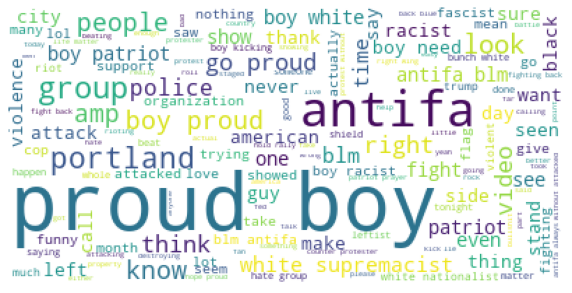

In [63]:
plt.figure(figsize=(10,7))
plt.imshow(wc_supportive)
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

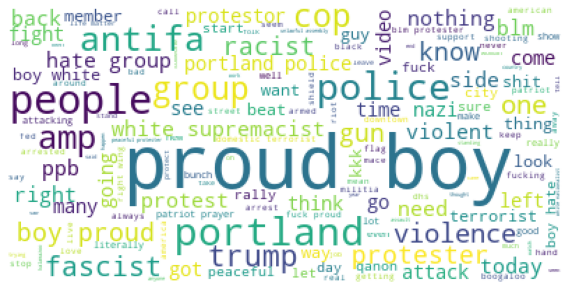

In [64]:
plt.figure(figsize=(10,7))
plt.imshow(wc_nonsupportive)
plt.axis('off')

**Removing Common Words**

In [74]:
from collections import Counter
MOST_COMMON = 20
counter_supportive = Counter(" ".join(data["text_proc"][data['Supportive'] == True]).split()).most_common(MOST_COMMON)
counter_nonsupportive = Counter(" ".join(data["text_proc"][data['Supportive'] == False]).split()).most_common(MOST_COMMON)

In [75]:
df1 = pd.DataFrame(counter_supportive, columns =['word', 'freq_supportive'])
df1 = df1.set_index('word')
df2 = pd.DataFrame(counter_nonsupportive, columns=['word', 'freq_non_supportive'])
df2 = df2.set_index('word')

common_supportive = pd.concat([df1,df2],axis=1)
#print(common_supportive)

remove_supportive = []
for idx, row in common_supportive.iterrows():
    if row[0] > 0 and row[1] > 0:
        remove_supportive.append(idx)

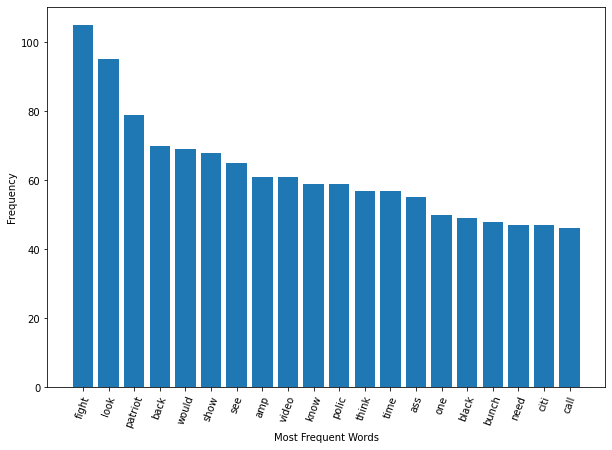

In [76]:
#counter_supportive.sort(key=lambda x: x[1], reverse=True)
plt.figure(figsize=(10,7))
plt.bar(range(len(counter_supportive)), [val[1] for val in counter_supportive], align='center')
plt.xlabel('Most Frequent Words')
plt.ylabel('Frequency')
plt.xticks(range(len(counter_supportive)), [val[0] for val in counter_supportive])
plt.xticks(rotation=70)
plt.show()

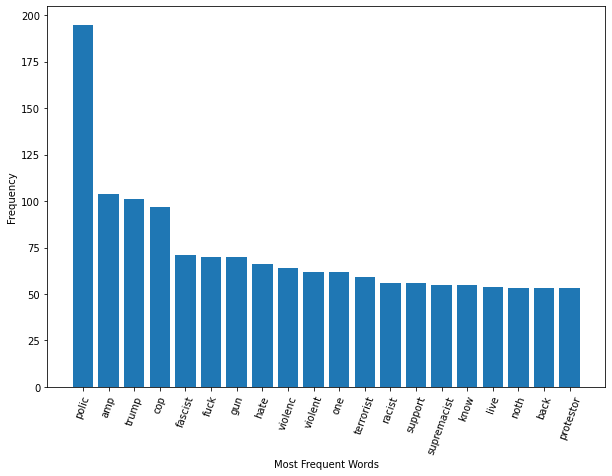

In [77]:
#counter_supportive.sort(key=lambda x: x[1], reverse=True)
plt.figure(figsize=(10,7))
plt.bar(range(len(counter_nonsupportive)), [val[1] for val in counter_nonsupportive], align='center')
plt.xlabel('Most Frequent Words')
plt.ylabel('Frequency')
plt.xticks(range(len(counter_nonsupportive)), [val[0] for val in counter_nonsupportive])
plt.xticks(rotation=70)
plt.show()

In [78]:
print(len(remove_supportive), remove_supportive)
print(common_supportive)
remove_supportive = set(remove_supportive)

5 ['back', 'amp', 'know', 'polic', 'one']
             freq_supportive  freq_non_supportive
fight                  105.0                  NaN
look                    95.0                  NaN
patriot                 79.0                  NaN
back                    70.0                 53.0
would                   69.0                  NaN
show                    68.0                  NaN
see                     65.0                  NaN
amp                     61.0                104.0
video                   61.0                  NaN
know                    59.0                 55.0
polic                   59.0                195.0
think                   57.0                  NaN
time                    57.0                  NaN
ass                     55.0                  NaN
one                     50.0                 62.0
black                   49.0                  NaN
bunch                   48.0                  NaN
need                    47.0                  NaN
citi    

In [79]:
for idx, row in data.iterrows():
    words = nltk.word_tokenize(row['text_proc'])
    words = [word for word in words if word not in remove_supportive]
    data.loc[idx, 'lem_text'] = ' '.join([lemmatizer.lemmatize(word) for word in words])
    words = [stemmer.stem(word) for word in words]
    data.loc[idx, 'text_proc'] = ' '.join(words)

In [80]:
wc_s = WordCloud(background_color='white', max_words=150, random_state=1)#, mask=mask)
wc_supportive = wc_s.generate(' '.join(data[data['Supportive'] == True]['lem_text']))

wc_ns = WordCloud(background_color='white', max_words=150, random_state=1)#, mask=mask)
wc_nonsupportive = wc_ns.generate(' '.join(data[data['Supportive'] == False]['lem_text']))

(-0.5, 399.5, 199.5, -0.5)

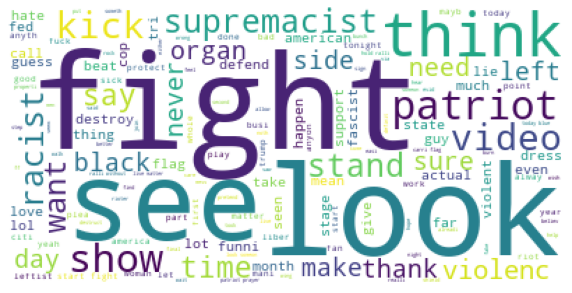

In [81]:
plt.figure(figsize=(10,7))
plt.imshow(wc_supportive)
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

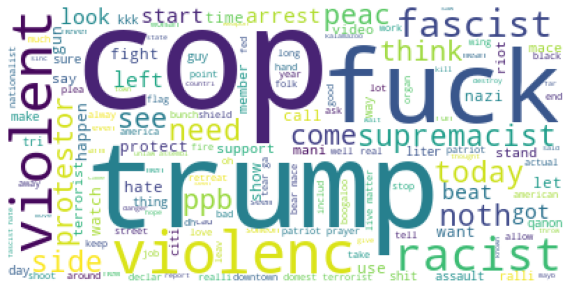

In [82]:
plt.figure(figsize=(10,7))
plt.imshow(wc_nonsupportive)
plt.axis('off')

# POS Tags

In [42]:
import spacy
#sp = spacy.load('en_core_web_sm')

import en_core_web_sm
sp = en_core_web_sm.load()

corpus = {word for text in data['text_proc'] for word in text.split()}
print(len(corpus))

sen = sp(' '.join(list(corpus)))
print(sen.text[:100])
#print(data.loc[0, 'lem_text'])

ModuleNotFoundError: No module named 'spacy'

In [304]:
pprint(len(' '.join(list(corpus))))

20773


In [305]:
print(len(sen))
for i in range(20):print(sen[i], sen[i].pos_)
print(spacy.explain(sen[0]))
print(spacy.explain(sen[0].tag_))

3232
aliv PROPN
origin PROPN
skirt PROPN
ring VERB
littl PROPN
soi PROPN
frame PROPN
masturb PROPN
concentr PROPN
rockefel PROPN
shitti PROPN
amateur PROPN
el PROPN
may VERB
peter PROPN
demonstr PROPN
club PROPN
flown VERB
ah INTJ
aintsh PROPN
None
noun, proper singular


# Linguistic Features

Bag of Words (**X1**)

In [83]:
# Bag of words
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features=2000) # CountVectorizer(ngram_range=(2,2))
X1 = cv.fit_transform(data['text_proc']).toarray()
print(type(X1))
print(X1.shape)

<class 'numpy.ndarray'>
(2514, 2000)


In [84]:
vocab = cv.vocabulary_

count_values = X1.sum(axis=0)

for ng_count, ng_text in sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True):
    if ng_text.count(' ') == 0:
        print(ng_count, ng_text)

144 fight
137 look
133 trump
125 patriot
119 cop
114 would
109 see
107 violenc
106 show
102 racist
101 think
99 need
97 terrorist
96 violent
96 time
95 supremacist
94 video
93 support
93 hate
92 fascist
91 live
85 today
85 start
85 fuck
84 left
83 call
79 want
79 side
79 black
78 gun
76 stand
75 beat
74 riot
73 peac
73 citi
73 bunch
71 noth
71 let
71 ass
70 say
70 got
69 shit
67 protestor
67 make
66 also
65 tri
64 guy
64 day
59 thing
59 take
59 sure
59 happen
57 watch
57 ralli
57 nazi
57 mace
57 come
56 even
55 kick
54 mani
53 stop
52 way
52 organ
52 arrest
51 protect
51 flag
50 member
50 blue
50 american
48 someon
48 assault
47 us
47 street
47 saw
47 ppb
47 matter
47 love
47 good
47 actual
46 use
46 never
46 lot
45 seem
45 far
44 vs
44 shield
44 seen
44 america
42 spray
42 real
41 work
41 realli
41 defend
41 bad
40 qanon
40 mean
40 domest
39 prayer
39 fed
39 destroy
39 counter
39 believ
39 alway
38 well
36 everi
36 declar
35 shoot
35 run
35 lol
35 guess
34 stage
34 point
34 nationalis

2 multnomah
2 mugshot
2 msdnc
2 mountain
2 motto
2 monday
2 modern
2 mislabl
2 minor
2 miniscul
2 mile
2 metal
2 mere
2 menac
2 memori
2 master
2 mass
2 masquerad
2 marx
2 martial
2 marshal
2 marri
2 marc
2 magat
2 machin
2 lui
2 luck
2 lrad
2 lock
2 lob
2 liquid
2 leo
2 legend
2 lean
2 le
2 lay
2 lawsuit
2 larger
2 lara
2 land
2 labor
2 la
2 kept
2 kati
2 karma
2 karl
2 june
2 judg
2 journalist
2 jew
2 jesu
2 jernigan
2 israel
2 irrelev
2 intimid
2 intersect
2 interpret
2 interf
2 instant
2 inspir
2 insan
2 initi
2 info
2 incel
2 inact
2 illeg
2 iiiiiiiiii
2 identitarian
2 hype
2 hurl
2 horn
2 homophob
2 hoax
2 hmmm
2 high
2 heavili
2 heart
2 heal
2 havoc
2 harm
2 harder
2 hahahahaha
2 haha
2 hack
2 grown
2 gross
2 greatest
2 grass
2 grab
2 gore
2 gl
2 gibson
2 georg
2 geniu
2 gee
2 gamer
2 furiou
2 fring
2 fred
2 frame
2 four
2 foundat
2 forev
2 forbid
2 footbal
2 focu
2 fn
2 fluffi
2 flu
2 flippant
2 five
2 femal
2 fb
2 fairli
2 extra
2 extend
2 express
2 expo
2 experienc
2 exerci
2

N-gram (**X3**)

1. Unigram: X3_1
2. Bigram: X3_2
3. Hybrid: X3_12

In [86]:
# N-Gram
from sklearn.feature_extraction.text import CountVectorizer
cv1 = CountVectorizer(ngram_range=(1,1))
cv2 = CountVectorizer(max_features=10000, ngram_range=(2,2))
cv12 = CountVectorizer(max_features=10000, ngram_range=(1,3))
X3_1 = cv1.fit_transform(data['text_proc']).toarray()
X3_2 = cv2.fit_transform(data['text_proc']).toarray()
X3_12 = cv12.fit_transform(data['text_proc']).toarray()

In [87]:
print(X3_1.shape, X3_2.shape, X3_12.shape)

(2514, 3203) (2514, 10000) (2514, 10000)


[('fight', 144), ('look', 137), ('trump', 133), ('patriot', 125), ('cop', 119), ('would', 114), ('see', 109), ('violenc', 107), ('show', 106), ('racist', 102), ('think', 101), ('need', 99), ('terrorist', 97), ('violent', 96), ('time', 96), ('supremacist', 95), ('video', 94), ('support', 93), ('hate', 93), ('fascist', 92), ('live', 91), ('today', 85), ('start', 85), ('fuck', 85), ('left', 84), ('call', 83), ('want', 79), ('side', 79), ('black', 79), ('gun', 78), ('stand', 76)]


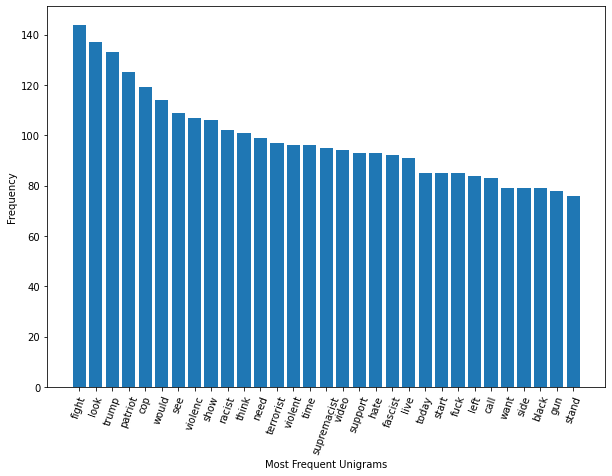

In [88]:
vocab = cv1.vocabulary_

count_values = X3_1.sum(axis=0)
temp = []
for i, (ng_count, ng_text) in enumerate(sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True)):
    temp.append((ng_text, ng_count))
    if i == 30:
        break
print(temp)

plt.figure(figsize=(10,7))
plt.bar(range(len(temp)), [val[1] for val in temp], align='center')
plt.xlabel('Most Frequent Unigrams')
plt.ylabel('Frequency')
plt.xticks(range(len(temp)), [val[0] for val in temp])
plt.xticks(rotation=70)
plt.show()

Term Frequence - Inverse Document Frequency (**X2**)

1. TF-IDF: X2

In [89]:
# TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
cv = TfidfVectorizer(max_features=2000)
X2 = cv.fit_transform(data['text_proc']).toarray()

In [90]:
X2.shape

(2514, 2000)

[('fight', 39.76154026047116), ('patriot', 34.06486971537741), ('look', 33.65283966694676), ('trump', 32.5764860499173), ('cop', 31.80857130247074), ('need', 30.473445530346968), ('think', 29.44231658443092), ('see', 28.424954592268445), ('would', 28.250175953297784), ('fuck', 28.21956894672962), ('supremacist', 28.17454842574192), ('racist', 27.980968772086563), ('terrorist', 27.180820088570922), ('show', 26.87622766767697), ('ass', 26.162634439513564), ('left', 24.90880499703538), ('time', 24.629605266112115), ('stand', 24.14833230622976), ('violenc', 24.011237484305337), ('call', 23.973183474893442), ('support', 23.955500495505465), ('side', 22.716024831017613), ('violent', 22.562104083074345), ('hate', 22.485144774577943), ('video', 22.46205121275137), ('kick', 22.438652760349854), ('noth', 22.258989231183925), ('start', 22.198272844551237), ('today', 21.946201004739684), ('fascist', 21.355692811649362), ('beat', 20.571454880262326)]


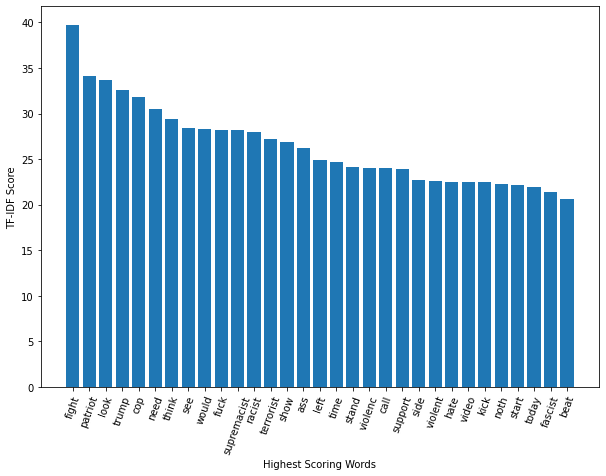

In [91]:
vocab = cv.vocabulary_

count_values = X2.sum(axis=0)
temp = []
for i, (ng_count, ng_text) in enumerate(sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True)):
    temp.append((ng_text, ng_count))
    if i == 30:
        break
print(temp)

plt.figure(figsize=(10,7))
plt.bar(range(len(temp)), [val[1] for val in temp], align='center')
plt.xlabel('Highest Scoring Words')
plt.ylabel('TF-IDF Score')
plt.xticks(range(len(temp)), [val[0] for val in temp])
plt.xticks(rotation=70)
plt.show()

In [380]:
# use when different features need different preprocessing
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV

pipeline = Pipeline([
    ('feats', FeatureUnion([
        ('cvec', CountVectorizer()),
        ('tfic', TfidfVectorizer()),
    ])),
    ('nb', MultinomialNB())
])

pipe_parms = [{
    'feats__cvec__max_features': [1000, 2000],
    'feats__cvec__ngram_range': [(1,1), (1,2), (1,3)],
    'feats__tfic__max_features': [1000, 2000],
    'feats__tfic__ngram_range': [(1,1), (1,2), (1,3)],    
}]

gs = GridSearchCV(pipeline, param_grid= pipe_parms, cv=5)
gs.fit(data.drop,)
# (OneHotEncoder(), ['Sex', 'Embarked']),
'''
column_trans = make_column_transformer(
    (CountVectorizer(max_features=2000), ['text_proc', 'hashtags_proc']),
    #(CountVectorizer(ngram_range=(1, 3), max_features=2000), ['text_proc']),
    (TfidfVectorizer(max_features=2000), ['text_proc', 'hashtags_proc']),
    remainder='passthrough')
X = data.drop('supportive', axis='columns')
column_trans.fit_transform(X)
'''

TypeError: Singleton array array(<bound method DataFrame.drop of                    user_id             status_id  \
0               x382691414  x1297365508300447744   
1               x743936431  x1297365466306904066   
2               x743936431  x1294749099976036353   
3               x375304364  x1297365456190406662   
4               x176941218  x1297365411533643776   
...                    ...                   ...   
2009   x964919111280193537  x1297277486020079616   
2010   x964919111280193537  x1297278244681547779   
2011  x1108609607650304000  x1297274560270626816   
2012             x20411327  x1295753648035725313   
2013   x795967977137065986  x1295105604751687680   

                                                   text   Y/N  \
0     Proud boys are attacking Peaceful protesters i...     N   
1     @Medde13 @MrAndyNgo I live in Portland, proud ...     N   
2     Anyone else wondering why tRump and his deplor...  N, O   
3     Not Antifa but the Right Wing Proud Boys. If y...     Y   
4     @MARCIAN2003 @JoshuaPotash The police and the ...     N   
...                                                 ...   ...   
2009  @percytex @ElijahSchaffer Proud boys and other...     Y   
2010  @smdh_atloser45 @EyeDrFigueroa @ryanoistacher ...     Y   
2011  @PortlandPolice Far right domestic terrorist p...     N   
2012  proud boys after hearing Joe's inauguration sp...  N, S   
2013  @NieceMotorsport @NatalieRacing So proud of yo...  Y, S   

      display_text_width  is_quote  favorite_count  retweet_count  \
0                    115     False               0              0   
1                    189     False               0              0   
2                    175     False               9              0   
3                    126      True               0              0   
4                     42     False               0              0   
...                  ...       ...             ...            ...   
2009                  45     False               2              0   
2010                  65     False               1              0   
2011                 142      True               1              1   
2012                 106     False               4              0   
2013                 262     False               2              0   

              hashtags  media_type  ... verified  Supportive  Offensive  \
0                  NaN       photo  ...    False       False      False   
1                  NaN  plain_text  ...    False       False      False   
2                  NaN  plain_text  ...    False       False       True   
3     CriticalThinking  plain_text  ...    False        True      False   
4                  NaN  plain_text  ...    False       False      False   
...                ...         ...  ...      ...         ...        ...   
2009               NaN  plain_text  ...    False        True      False   
2010               NaN  plain_text  ...    False        True      False   
2011               NaN  plain_text  ...    False       False      False   
2012               NaN  plain_text  ...    False       False      False   
2013               NaN  plain_text  ...    False        True      False   

         hashtags_proc  hashtags_count  mention_count  exclamation_count  \
0                blank               0              0                  0   
1                blank               0              2                  0   
2                blank               0              0                  0   
3     criticalthinking               1              0                  0   
4                blank               0              2                  0   
...                ...             ...            ...                ...   
2009             blank               0              2                  0   
2010             blank               0              4                  0   
2011             blank               0              1                  0   
2012             blank               0              0                  0   
2013             blank               0              2                  0   

      question_count                                          text_proc  \
0                  0                                    peac protest dh   
1                  0  live supremacist hate trust us took street sid...   
2                  1  anyon el wonder trump deplor base speak condem...   
3                  0              wing think far left cau destruct chao   
4                  0                                              polic   
...              ...                                                ...   
2009               0                                      patriot heard   
2010               0                                still lie take beat   
2011               3  far domest terrorist patriot prayer destroy pr...   
2012               0  hear joe inaugur speech wtf social liber fisca...   
2013               0  push love listen spotter coach strong person i...   

                                               lem_text  
0                                       peac protest dh  
1     live supremacist hate trust u took street side...  
2     anyon el wonder trump deplor base speak condem...  
3                wing think far left caus destruct chao  
4                                                 polic  
...                                                 ...  
2009                                      patriot heard  
2010                                still lie take beat  
2011  far domest terrorist patriot prayer destroy pr...  
2012  hear joe inaugur speech wtf social liber fisca...  
2013  push love listen spotter coach strong person i...  

[2014 rows x 26 columns]>, dtype=object) cannot be considered a valid collection.

Word2Vec (**X4**)

In [177]:
# source: http://nadbordrozd.github.io/blog/2016/05/20/text-classification-with-word2vec/

class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(list(word2vec.values())[0])

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

In [185]:
from gensim.models import Word2Vec

corpus = [text.split() for text in data['text_proc']]
model_w2v = Word2Vec(sentences=corpus, size=100, window=5, min_count=1, workers=4)
#words = model_w2v.wv.vocab

embedding_w2v = dict(zip(model_w2v.wv.index2word, model_w2v.wv.vectors))


w2v = MeanEmbeddingVectorizer(embedding_w2v)
X4 = cv.fit_transform(data['text_proc']).toarray()
print(type(X4))
print(X4.shape)

<class 'numpy.ndarray'>
(2514, 2000)


Processing the Labels (**y**)

In [92]:
# Labels for Supportive / Non supportive
y = pd.get_dummies(data['Supportive'])
y = y.iloc[:, 1].values
print(y[:6], y.shape)

[0 0 0 0 0 0] (2514,)


In [93]:
data.columns

Index(['user_id', 'status_id', 'text', 'Y/N', 'display_text_width', 'is_quote',
       'favorite_count', 'retweet_count', 'hashtags', 'media_type',
       'mentions_screen_name', 'followers_count', 'friends_count',
       'listed_count', 'statuses_count', 'favourites_count', 'verified',
       'Supportive', 'Offensive', 'hashtags_proc', 'hashtags_count',
       'mention_count', 'exclamation_count', 'question_count', 'text_proc',
       'lem_text'],
      dtype='object')

One Hot Encoding:

    1. hashtags_count -> X_10
    2. mention_count  -> X_11
    3. exclamation_count -> X_12
    4. question_count    -> X_13
    5. is_quote -> X_14
    6. media_type -> X_15

In [94]:
from sklearn.preprocessing import OneHotEncoder

In [95]:
ohe = OneHotEncoder(sparse=False)
X_10 = ohe.fit_transform(data[['hashtags_count']])
#print(data.loc[:20, 'hashtags_count'])

X_11 = ohe.fit_transform(data[['mention_count']])
#print(data.loc[:20, 'mention_count'])

X_12 = ohe.fit_transform(data[['exclamation_count']])

X_13 = ohe.fit_transform(data[['question_count']])

X_14 = ohe.fit_transform(data[['is_quote']])
#print(data.loc[:20, 'is_quote'])
#print(X_14[:20])

X_15 = ohe.fit_transform(data[['media_type']])

X_16 = ohe.fit_transform(data[['verified']])

X_20 -> 'display_text_width', 'favorite_count', 'retweet_count'

In [96]:
X_20 = data[['display_text_width', 'favorite_count', 'retweet_count']].to_numpy()
print(X_20.shape)

(2514, 3)


1. X_21 -> 'mentions_screen_name'
2. X_22 -> 'hashtags_proc'

In [97]:
#Hashtags #Mentions
# Bag of words
from sklearn.feature_extraction.text import CountVectorizer
cv21 = CountVectorizer()
X_21 = cv21.fit_transform(data['hashtags_proc']).toarray()

cv22 = CountVectorizer()
X_22 = cv22.fit_transform(data['mentions_screen_name']).toarray()

print(X_21.shape, X_22.shape)

(2514, 135) (2514, 1008)


# Classifiers

Bag of Words (**X1**)

Term Frequence - Inverse Document Frequency (**X2**)

N-gram (**X3**)
1. Unigram: X3_1
2. Bigram: X3_2
3. Hybrid: X3_12

Word2Vec (**X4**)

One Hot Encoding:
1. hashtags_count -> X_10
2. mention_count  -> X_11
3. exclamation_count -> X_12
4. question_count    -> X_13
5. is_quote -> X_14
6. media_type -> X_15

Integer feature:

0. 'display_text_width', 'favorite_count', 'retweet_count' -> X_20
1. 'mentions_screen_name' -> X_21
2. 'hashtags_proc' -> X_22



In [257]:
#X2, X3_1, X3_2, X3_12, X_10, X_11, X_12, X_13, X_14, X_15, X_16, X_20, X_21, X_22
#from scipy.sparse import hstack
#X2, X3_1, X3_2,
X = np.hstack([X2, X3_1, X3_2, X4, X_10, X_11, X_12, X_13, X_14, X_15, X_16, X_21, X_22])
#X.shape
print(X.shape)

(2514, 18368)


Train Test Split (**X_train, y_train, X_test, y_test**)

In [258]:
# Train Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

In [259]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2011, 18368) (503, 18368) (2011,) (503,)


Naive Bayes

[[156  94]
 [ 18 235]]
              precision    recall  f1-score   support

           0       0.90      0.62      0.74       250
           1       0.71      0.93      0.81       253

    accuracy                           0.78       503
   macro avg       0.81      0.78      0.77       503
weighted avg       0.80      0.78      0.77       503

Accuracy: 77.73359840954275%, Precision: 71.42857142857143%, Recall: 92.88537549407114%, F1-score: 80.75601374570446%


Text(0, 0.5, 'True Positive Rate')

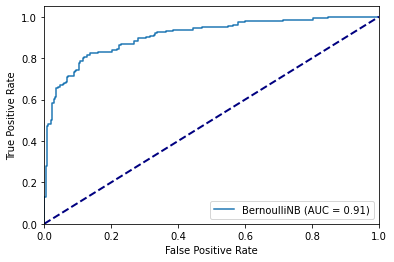

In [260]:
from sklearn.naive_bayes import BernoulliNB
model_NB = BernoulliNB().fit(X_train, y_train)
y_pred_NB = model_NB.predict(X_test)

from sklearn.metrics import confusion_matrix
confusion_m = confusion_matrix(y_test, y_pred_NB)
print(confusion_m)

show_result(y_test, y_pred_NB)

from sklearn.metrics import roc_auc_score, plot_roc_curve
roc_auc_score(y_test, y_pred_NB)
plot_roc_curve(model_NB, X_test, y_test)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

Random Forest

[[195  55]
 [ 25 228]]
              precision    recall  f1-score   support

           0       0.89      0.78      0.83       250
           1       0.81      0.90      0.85       253

    accuracy                           0.84       503
   macro avg       0.85      0.84      0.84       503
weighted avg       0.85      0.84      0.84       503

Accuracy: 84.09542743538768%, Precision: 80.56537102473497%, Recall: 90.11857707509881%, F1-score: 85.07462686567163%


(0.0, 1.05)

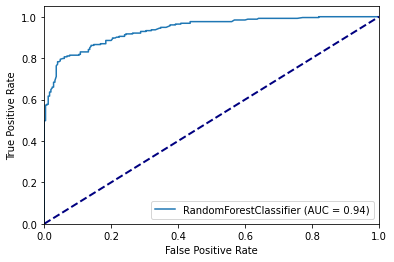

In [261]:
from sklearn.ensemble import RandomForestClassifier
model_RF = RandomForestClassifier(n_estimators=200, criterion='entropy').fit(X_train, y_train)
y_pred_RF = model_RF.predict(X_test)

from sklearn.metrics import confusion_matrix
confusion_m = confusion_matrix(y_test, y_pred_RF)
print(confusion_m)

show_result(y_test, y_pred_RF)

from sklearn.metrics import roc_auc_score, plot_roc_curve
roc_auc_score(y_test, y_pred_RF)
plot_roc_curve(model_RF, X_test, y_test)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

[[203  47]
 [ 35 218]]
              precision    recall  f1-score   support

           0       0.85      0.81      0.83       250
           1       0.82      0.86      0.84       253

    accuracy                           0.84       503
   macro avg       0.84      0.84      0.84       503
weighted avg       0.84      0.84      0.84       503

Accuracy: 83.69781312127238%, Precision: 82.26415094339623%, Recall: 86.16600790513834%, F1-score: 84.16988416988417%


(0.0, 1.05)

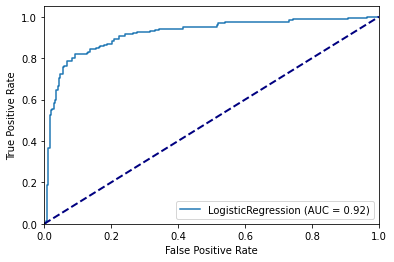

In [262]:
from sklearn.linear_model import LogisticRegression
model_LR = LogisticRegression(random_state=1234).fit(X_train, y_train)
y_pred_LR = model_LR.predict(X_test)

from sklearn.metrics import confusion_matrix
confusion_m = confusion_matrix(y_test, y_pred_LR)
print(confusion_m)

show_result(y_test, y_pred_LR)

from sklearn.metrics import roc_auc_score, plot_roc_curve
roc_auc_score(y_test, y_pred_LR)
plot_roc_curve(model_LR, X_test, y_test)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

[[192  58]
 [ 38 215]]
              precision    recall  f1-score   support

           0       0.83      0.77      0.80       250
           1       0.79      0.85      0.82       253

    accuracy                           0.81       503
   macro avg       0.81      0.81      0.81       503
weighted avg       0.81      0.81      0.81       503

Accuracy: 80.9145129224652%, Precision: 78.75457875457876%, Recall: 84.98023715415019%, F1-score: 81.7490494296578%


(0.0, 1.05)

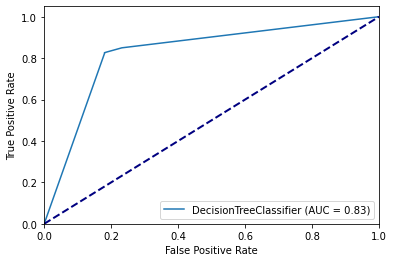

In [263]:
from sklearn.tree import DecisionTreeClassifier
model_DT = DecisionTreeClassifier(criterion="entropy").fit(X_train, y_train)
y_pred_DT = model_DT.predict(X_test)

from sklearn.metrics import confusion_matrix
confusion_m = confusion_matrix(y_test, y_pred_DT)
print(confusion_m)

show_result(y_test, y_pred_DT)

from sklearn.metrics import roc_auc_score, plot_roc_curve
roc_auc_score(y_test, y_pred_DT)
plot_roc_curve(model_DT, X_test, y_test)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

[[202  48]
 [ 32 221]]
              precision    recall  f1-score   support

           0       0.86      0.81      0.83       250
           1       0.82      0.87      0.85       253

    accuracy                           0.84       503
   macro avg       0.84      0.84      0.84       503
weighted avg       0.84      0.84      0.84       503

Accuracy: 84.09542743538768%, Precision: 82.15613382899627%, Recall: 87.35177865612648%, F1-score: 84.67432950191571%


(0.0, 1.05)

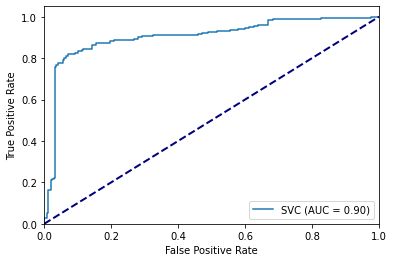

In [264]:
from sklearn.svm import SVC
model_SV = SVC(kernel='linear').fit(X_train, y_train)
y_pred_SV = model_SV.predict(X_test)

from sklearn.metrics import confusion_matrix
confusion_m = confusion_matrix(y_test, y_pred_SV)
print(confusion_m)

show_result(y_test, y_pred_SV)

from sklearn.metrics import roc_auc_score, plot_roc_curve
roc_auc_score(y_test, y_pred_SV)
plot_roc_curve(model_SV, X_test, y_test)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

[[215  35]
 [ 42 211]]
              precision    recall  f1-score   support

           0       0.84      0.86      0.85       250
           1       0.86      0.83      0.85       253

    accuracy                           0.85       503
   macro avg       0.85      0.85      0.85       503
weighted avg       0.85      0.85      0.85       503

Accuracy: 84.69184890656064%, Precision: 85.77235772357723%, Recall: 83.399209486166%, F1-score: 84.5691382765531%


(0.0, 1.05)

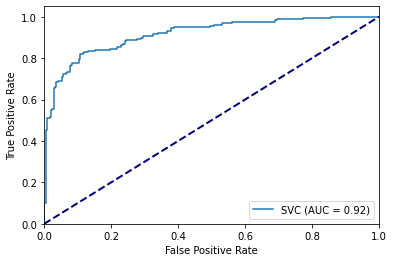

In [265]:
from sklearn.svm import SVC
model_SV_rbf = SVC(kernel='rbf').fit(X_train, y_train)
y_pred_SV_rbf = model_SV_rbf.predict(X_test)

from sklearn.metrics import confusion_matrix
confusion_m = confusion_matrix(y_test, y_pred_SV_rbf)
print(confusion_m)

show_result(y_test, y_pred_SV_rbf)

from sklearn.metrics import roc_auc_score, plot_roc_curve
roc_auc_score(y_test, y_pred_SV_rbf)
plot_roc_curve(model_SV_rbf, X_test, y_test)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

[[209  41]
 [ 51 202]]
              precision    recall  f1-score   support

           0       0.80      0.84      0.82       250
           1       0.83      0.80      0.81       253

    accuracy                           0.82       503
   macro avg       0.82      0.82      0.82       503
weighted avg       0.82      0.82      0.82       503

Accuracy: 81.70974155069582%, Precision: 83.1275720164609%, Recall: 79.84189723320159%, F1-score: 81.45161290322581%


(0.0, 1.05)

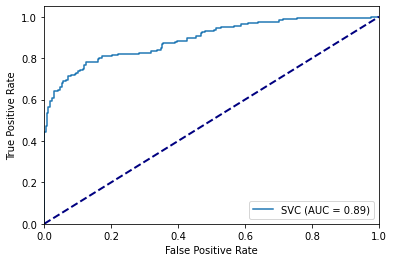

In [266]:
from sklearn.svm import SVC
model_SV_poly = SVC(kernel='poly').fit(X_train, y_train)
y_pred_SV_poly = model_SV_poly.predict(X_test)

from sklearn.metrics import confusion_matrix
confusion_m = confusion_matrix(y_test, y_pred_SV_poly)
print(confusion_m)

show_result(y_test, y_pred_SV_poly)

from sklearn.metrics import roc_auc_score, plot_roc_curve
roc_auc_score(y_test, y_pred_SV_poly)
plot_roc_curve(model_SV_poly, X_test, y_test)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

[[196  54]
 [ 48 205]]
              precision    recall  f1-score   support

           0       0.80      0.78      0.79       250
           1       0.79      0.81      0.80       253

    accuracy                           0.80       503
   macro avg       0.80      0.80      0.80       503
weighted avg       0.80      0.80      0.80       503

Accuracy: 79.72166998011929%, Precision: 79.15057915057915%, Recall: 81.02766798418972%, F1-score: 80.078125%


(0.0, 1.05)

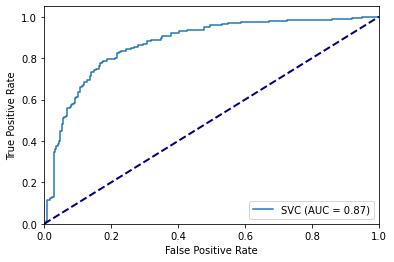

In [267]:
from sklearn.svm import SVC
model_SV_sig = SVC(kernel='sigmoid').fit(X_train, y_train)
y_pred_SV_sig = model_SV_sig.predict(X_test)

from sklearn.metrics import confusion_matrix
confusion_m = confusion_matrix(y_test, y_pred_SV_sig)
print(confusion_m)

show_result(y_test, y_pred_SV_sig)

from sklearn.metrics import roc_auc_score, plot_roc_curve
roc_auc_score(y_test, y_pred_SV_sig)
plot_roc_curve(model_SV_sig, X_test, y_test)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

#XGBoost

In [268]:
# source: https://www.kaggle.com/tilii7/hyperparameter-grid-search-with-xgboost
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

# A parameter grid for XGBoost
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }


xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic', silent=True, nthread=1)


folds = 4
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)
random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='roc_auc', 
                                   n_jobs=4, cv=skf.split(X_train, y_train), verbose=3, random_state=1001)

random_search.fit(X_train, y_train)

Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed: 45.6min remaining:    0.0s
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed: 45.6min finished
C:\Users\Fahim\Anaconda3\envs\social_media_mining\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[05:05:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[05:05:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x0000025E9098BF20>,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=0.02,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, mis...
                                           random_state=None, reg_alpha=None,
                                           reg_lambda=None,
                                           scale_pos_weight=None, silent=True,
                                           subsa

In [269]:
print('\n All results:')
#pprint(random_search.cv_results_)
print('\n Best estimator:')
pprint(random_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(random_search.best_params_)
results = pd.DataFrame(random_search.cv_results_)
results.to_csv('xgb-random-grid-search-results-01.csv', index=False)


 All results:

 Best estimator:
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0, gamma=1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.02, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=600, n_jobs=1, nthread=1, num_parallel_tree=1,
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              silent=True, subsample=0.8, tree_method='exact',
              validate_parameters=1, verbosity=None)

 Best normalized gini score for 4-fold search with 5 parameter combinations:
0.6352791735732086

 Best hyperparameters:
{'subsample': 0.8, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 1, 'colsample_bytree': 1.0}


[[193  57]
 [ 60 193]]
              precision    recall  f1-score   support

           0       0.76      0.77      0.77       250
           1       0.77      0.76      0.77       253

    accuracy                           0.77       503
   macro avg       0.77      0.77      0.77       503
weighted avg       0.77      0.77      0.77       503

Accuracy: 76.73956262425448%, Precision: 77.2%, Recall: 76.28458498023716%, F1-score: 76.73956262425448%


(0.0, 1.05)

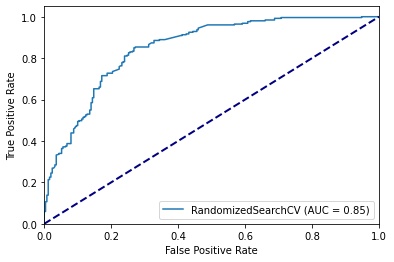

In [270]:
y_pred_xgb = random_search.predict(X_test)

from sklearn.metrics import confusion_matrix
confusion_m = confusion_matrix(y_test, y_pred_xgb)
print(confusion_m)

show_result(y_test, y_pred_xgb)

from sklearn.metrics import roc_auc_score, plot_roc_curve
roc_auc_score(y_test, y_pred_xgb)
plot_roc_curve(random_search, X_test, y_test)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

Neural Network

Epoch 1/600
63/63 [==============================] - 0s 6ms/step - loss: 0.6777 - val_loss: 0.6519
Epoch 2/600
63/63 [==============================] - 0s 4ms/step - loss: 0.5980 - val_loss: 0.5613
Epoch 3/600
63/63 [==============================] - 0s 5ms/step - loss: 0.4552 - val_loss: 0.4372
Epoch 4/600
63/63 [==============================] - 0s 5ms/step - loss: 0.3042 - val_loss: 0.3789
Epoch 5/600
63/63 [==============================] - 0s 5ms/step - loss: 0.1931 - val_loss: 0.3673
Epoch 6/600
63/63 [==============================] - 0s 4ms/step - loss: 0.1466 - val_loss: 0.3770
Epoch 7/600
63/63 [==============================] - 0s 4ms/step - loss: 0.1013 - val_loss: 0.3988
Epoch 8/600
63/63 [==============================] - 0s 5ms/step - loss: 0.0940 - val_loss: 0.4222
Epoch 9/600
63/63 [==============================] - 0s 4ms/step - loss: 0.0708 - val_loss: 0.4685
Epoch 10/600
63/63 [==============================] - ETA: 0s - loss: 0.052 - 0s 4ms/step - loss: 0.0533 - va

<AxesSubplot:>

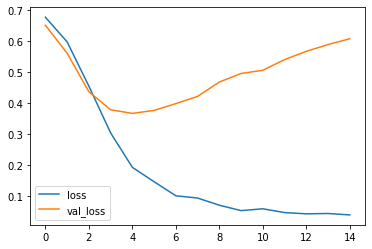

In [271]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout

model_ann = Sequential()
model_ann.add(Dense(units=30,activation='relu'))
model_ann.add(Dropout(0.5))

model_ann.add(Dense(units=15,activation='relu'))
model_ann.add(Dropout(0.5))

model_ann.add(Dense(units=1,activation='sigmoid'))
model_ann.compile(loss='binary_crossentropy', optimizer='adam')

from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

model_ann.fit(x=X_train, 
          y=y_train, 
          epochs=600,
          validation_data=(X_test, y_test), verbose=1,
          callbacks=[early_stop]
          )

model_ann_loss = pd.DataFrame(model_ann.history.history)
model_ann_loss.plot()

[[209  41]
 [ 30 223]]
              precision    recall  f1-score   support

           0       0.87      0.84      0.85       250
           1       0.84      0.88      0.86       253

    accuracy                           0.86       503
   macro avg       0.86      0.86      0.86       503
weighted avg       0.86      0.86      0.86       503

Accuracy: 85.88469184890656%, Precision: 84.46969696969697%, Recall: 88.14229249011858%, F1-score: 86.26692456479691%
0.9249169960474309


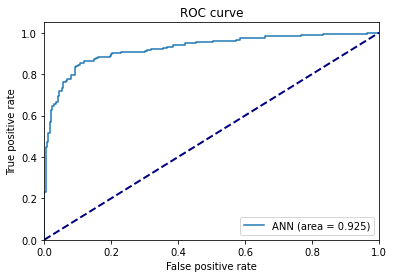

In [272]:
y_pred_ann = model_ann.predict_classes(X_test).flatten()

from sklearn.metrics import confusion_matrix
confusion_m = confusion_matrix(y_test, y_pred_ann)
print(confusion_m)

show_result(y_test, y_pred_ann)

from sklearn.metrics import roc_curve
y_pred_ann = model_ann.predict(X_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_ann)

from sklearn.metrics import roc_auc_score, plot_roc_curve
auc_keras = roc_auc_score(y_test, y_pred_ann)
print(auc_keras)
#plot_roc_curve(model_ann, X_test, np.reshape(y_test, (-1, 1)))


plt.plot(fpr_keras, tpr_keras, label='ANN (area = {:.3f})'.format(auc_keras))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

## Helpers

In [273]:
def show_result(y_test, y_pred):
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    print(report)
    print(f'Accuracy: {accuracy*100}%, Precision: {precision*100}%, Recall: {recall*100}%, F1-score: {f1*100}%')
    
    from sklearn.metrics import roc_auc_score
    roc_auc_score(y_test, y_pred)


 **BEFORE removing URLs, Hashtags, Mentions; MOST_COMMON = 0**
 
 *BAG OF WORDS*

 
 Model           | Accuracy      |Precision     |Recall        |F1-score   
 ----------------|---------------|--------------|--------------|-----------
 Naive Bayes     | 0.76          | 0.65         | 0.72         | 0.68 
 Random Forest   | 0.73          | 0.62         | 0.66         | 0.64

 
 *TF - IDF*

 
 Model           | Accuracy      |Precision     |Recall        |F1-score   
 ----------------|---------------|--------------|--------------|-----------
 Naive Bayes     | 0.75          | 0.79         | 0.40         | 0.53 
 Random Forest   | 0.75          | 0.72         | 0.50         | 0.59
 
 
 **AFTER removing URLs, Hashtags, Mentions; MOST_COMMON = 0**
 
 *BAG OF WORDS*

 
 Model           | Accuracy      |Precision     |Recall        |F1-score   
 ----------------|---------------|--------------|--------------|-----------
 Naive Bayes     | 0.75          | 0.66         | 0.64         | 0.65 
 Random Forest   | 0.73          | 0.63         | 0.58         | 0.60

 
 *TF - IDF*

 
 Model           | Accuracy      |Precision     |Recall        |F1-score   
 ----------------|---------------|--------------|--------------|-----------
 Naive Bayes     | 0.75          | 0.66         | 0.64         | 0.65 
 Random Forest   | 0.70          | 0.60         | 0.56         | 0.58

In [274]:
from emoji import UNICODE_EMOJI

def is_emoji(s):
    count = 0
    for emoji in UNICODE_EMOJI:
        count += s.count(emoji)
        if count > 1:
            return False
    return bool(count)

In [275]:
def extract_emojis(s):
    return ''.join(c for c in s if c in UNICODE_EMOJI)

## Multiple ROC Curve in a SINGLE PLOT
https://abdalimran.github.io/2019-06-01/Drawing-multiple-ROC-Curves-in-a-single-plot

In [276]:
# Import the classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import roc_curve, roc_auc_score

# Instantiate the classfiers and make a list
classifiers = [LogisticRegression(random_state=1234), 
               GaussianNB(), 
               KNeighborsClassifier(), 
               DecisionTreeClassifier(random_state=1234),
               RandomForestClassifier(random_state=1234)]

# Define a result table as a DataFrame
result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

# Train the models and record the results
for cls in classifiers:
    model = cls.fit(X_train, y_train)
    yproba = model.predict_proba(X_test)[::,1]
    
    fpr, tpr, _ = roc_curve(y_test,  yproba)
    auc = roc_auc_score(y_test, yproba)
    
    result_table = result_table.append({'classifiers':cls.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)

# Set name of the classifiers as index labels
result_table.set_index('classifiers', inplace=True)

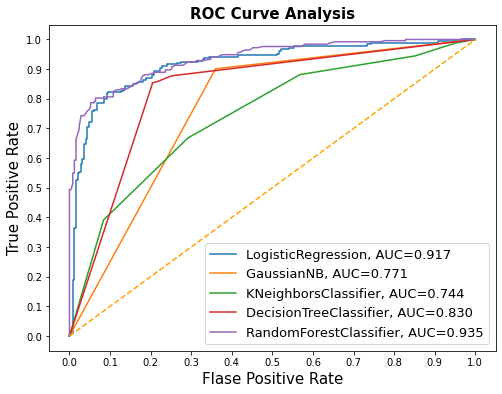

In [277]:
fig = plt.figure(figsize=(8,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Flase Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

In [306]:
result_table

,fpr,tpr,auc
classifiers,,,
LogisticRegression,"[0.0, 0.0, 0.004, 0.004, 0.008, 0.008, 0.008, ...","[0.0, 0.003952569169960474, 0.0039525691699604...",0.917202
GaussianNB,"[0.0, 0.36, 1.0]","[0.0, 0.9011857707509882, 1.0]",0.770593
KNeighborsClassifier,"[0.0, 0.084, 0.292, 0.568, 0.852, 0.952, 1.0]","[0.0, 0.391304347826087, 0.6679841897233202, 0...",0.744079
DecisionTreeClassifier,"[0.0, 0.204, 0.204, 0.216, 0.252, 1.0]","[0.0, 0.849802371541502, 0.8537549407114624, 0...",0.830356
RandomForestClassifier,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.05533596837944664, 0.14624505928853754...",0.934601


In [313]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
report = classification_report(y_test, y_pred)
conf_mat = confusion_matrix(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.76      0.77      0.76       250
           1       0.77      0.76      0.77       253

    accuracy                           0.77       503
   macro avg       0.77      0.77      0.77       503
weighted avg       0.77      0.77      0.77       503



<AxesSubplot:>

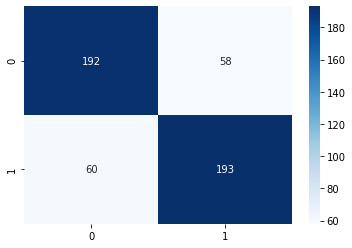

In [318]:
import seaborn as sns
sns.heatmap(conf_mat,#/np.sum(conf_mat), 
            annot=True,
            fmt='d',#'.2%',
            cmap='Blues'
           )